# Example Likelihood Test

This notebook tests the implementation of a standard minimal firecrown likelihood which can be used with the blinding library.

In [23]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pylab as plt
from firecrown.likelihood.likelihood import load_likelihood
from firecrown.likelihood.likelihood import load_likelihood_from_module_type
from firecrown.likelihood.likelihood import NamedParameters
from firecrown.parameters import ParamsMap
from firecrown.utils import save_to_sacc
import numpy as np
import sacc
import pathlib
import pyccl as ccl
from firecrown.modeling_tools import ModelingTools
import firecrown
import sys
import os
from copy import deepcopy

from blinding import Smokescreen

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
sys.path.append("../examples/cosmic_shear/")
import cosmicshear_likelihood

First let's try to pass the sacc as a string

In [13]:
sacc_file = "../examples/cosmic_shear/cosmicshear_sacc.fits"
build_parameters = NamedParameters({
    "sacc_data": sacc_file,
})
likelihood, tools = load_likelihood_from_module_type(cosmicshear_likelihood, build_parameters)

In [14]:
build_parameters.data['sacc_data']

'../examples/cosmic_shear/cosmicshear_sacc.fits'

In [15]:
likelihood.get_data_vector()

array([8.68664926e-09, 4.83660661e-09, 2.14902577e-09, 8.38689728e-10,
       3.29653471e-10, 1.35937954e-10, 4.99982193e-11, 1.39742692e-11,
       3.07364829e-12, 6.00642443e-13, 1.45234282e-08, 9.00288602e-09,
       4.26223992e-09, 1.63728386e-09, 6.32897033e-10, 2.63589025e-10,
       1.00965763e-10, 3.14823356e-11, 7.41193727e-12, 1.46985175e-12,
       2.94891553e-08, 2.09520287e-08, 1.09428163e-08, 4.47545278e-09,
       1.67488389e-09, 6.67403009e-10, 2.66481401e-10, 9.29506616e-11,
       2.43582380e-11, 5.16257092e-12])

Now let's try to pass the loaded sacc object

In [16]:
sacc_file = "../examples/cosmic_shear/cosmicshear_sacc.fits"
sacc_data = sacc.Sacc.load_fits(sacc_file)
build_parameters =  NamedParameters({
    "sacc_data": sacc_data,
})
likelihood, tools = load_likelihood_from_module_type(cosmicshear_likelihood, build_parameters)

In [17]:
likelihood.get_data_vector()

array([8.68664926e-09, 4.83660661e-09, 2.14902577e-09, 8.38689728e-10,
       3.29653471e-10, 1.35937954e-10, 4.99982193e-11, 1.39742692e-11,
       3.07364829e-12, 6.00642443e-13, 1.45234282e-08, 9.00288602e-09,
       4.26223992e-09, 1.63728386e-09, 6.32897033e-10, 2.63589025e-10,
       1.00965763e-10, 3.14823356e-11, 7.41193727e-12, 1.46985175e-12,
       2.94891553e-08, 2.09520287e-08, 1.09428163e-08, 4.47545278e-09,
       1.67488389e-09, 6.67403009e-10, 2.66481401e-10, 9.29506616e-11,
       2.43582380e-11, 5.16257092e-12])

In [18]:
list(likelihood.required_parameters().get_params_names())

['trc0_delta_z', 'trc1_delta_z']

## Testing now with the blinding library

In [19]:
cosmo = ccl.CosmologyVanillaLCDM()
syst_dict = {
    "trc1_delta_z": 0.1,
    "trc0_delta_z": 0.1,
    }
shift_dict = {"Omega_c": 0.34,}
sck = Smokescreen(cosmo, syst_dict, cosmicshear_likelihood, shift_dict, sacc_data)

In [20]:
sck.calculate_blinding_factor()

In [21]:
blinded_datavect = sck.apply_blinding_to_likelihood_datavec()

In [22]:
sck.likelihood.get_sacc_indices()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [ ]:
skc.likelihood.

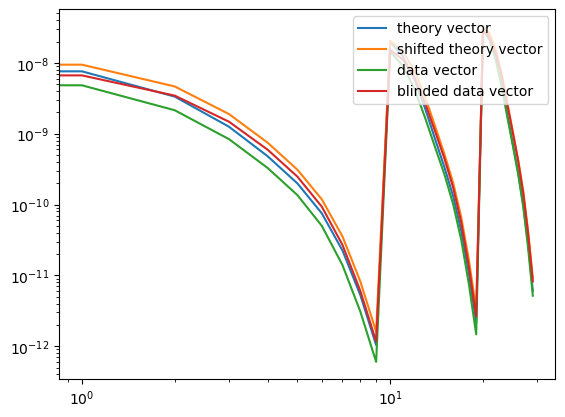

In [9]:
plt.figure()
plt.loglog(sck.theory_vec_fid, label='theory vector')
plt.loglog(sck.theory_vec_blind, label='shifted theory vector')
plt.loglog(sck.likelihood.get_data_vector(), label='data vector')
plt.loglog(blinded_datavect, label='blinded data vector')
plt.legend(loc=1)
plt.show()

In [29]:
sacc_test = save_to_sacc(sacc_data, blinded_datavect, sck.likelihood.get_sacc_indices())

In [30]:
sacc_test.sa